In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

C:\Users\jiahaozhang\AppData\Local\Temp\ipykernel_47864\1226147920.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [2]:
#nsd_root   = "/home/styvesg/repo.data/datasets/nsd/"
nsd_root = "C:/Data/nsd_test/"
stim_root  = nsd_root + "nsddata_stimuli/stimuli/nsd/"
synth_root = nsd_root + "nsddata_stimuli/stimuli/nsdsynthetic/"
beta_root  = nsd_root + "nsddata_betas/ppdata/"

nsd_root0 = "C:/Data/nsd/"
beta_root0  = nsd_root0 + "nsddata_betas/ppdata/"

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"
synth_design_file = nsd_root + "nsddata/experiments/nsdsynthetic/nsdsynthetic_expdesign.mat"
stim_file       = stim_root + "nsd_stimuli.hdf5"
synth_file      = synth_root + "nsdsynthetic_stimuli.hdf5"

# Stimulus-driven predictive model of brain activity.
What we will need:
- "imagenet_trained_model_weights.pkl"
- The betas and experiment stimuli
- A brain mask

In [11]:
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict, zip_dict
from src.config import *

%matplotlib inline

In [22]:
import torch
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: NVIDIA GeForce RTX 2080

torch: 2.6.0+cu126
cuda:  12.6
cudnn: 90501
dtype: torch.float32


In [23]:
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime()) # 'Aug-10-2020_1638' #

model_name = 'anet_fwrf_nsdgeneral'
model_dir = '%s_%s' % (model_name, timestamp)

output_dir = root_dir+"output/multisubject/%s_%s/" % (model_name,timestamp) 

trn_subjects = [1,2,3,4,5,6,7,8]
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)   
print ("Time Stamp: %s" % timestamp)

Time Stamp: May-03-2025_1335


In [9]:
trn_subjects=[1]

# Load the stimuli images

In [18]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
for s in trn_subjects: 
    image_data_set = h5py.File(stim_dir + "S%d_stimuli_227.h5py"%s, 'r')
    image_data[s] = np.copy(image_data_set['stimuli'])
    image_data_set.close()
    print ('--------  subject %d  -------' % s)
    print ('block size:', image_data[s].shape, ', dtype:', image_data[s].dtype, ', value range:',\
           np.min(image_data[s][0]), np.max(image_data[s][0]))

--------  subject 1  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


# Load the voxel data
- We load a subset (a range of voxels) of all voxel for the sake of the example.

In [4]:
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi

In [5]:
beta_dir = 'C:/Data/nsd/nsddata_betas/ppdata/'

In [12]:
group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]

brain_nii_shape, voxel_mask, voxel_idx, voxel_roi, voxel_ncsnr = {}, {}, {}, {}, {}

for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    #voxel_mask_full = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/brainmask_vcventral_1.0.nii"%s)
    voxel_mask_full = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/brainmask_nsdgeneral_1.0.nii"%s)
    voxel_roi_full  = load_mask_from_nii(mask_dir0 + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%s)
    voxel_kast_full = load_mask_from_nii(mask_dir0 + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(s))
    general_mask_full  = load_mask_from_nii(mask_dir0 + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(s))
    ncsnr_full = load_mask_from_nii(beta_dir + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/ncsnr.nii.gz"%s)
    ###
    brain_nii_shape[s] = voxel_roi_full.shape
    #print (brain_nii_shape[s])
    ###
    voxel_roi_mask_full = (voxel_roi_full>0).flatten().astype(bool)
    voxel_joined_roi_full = np.copy(voxel_kast_full.flatten())  # load kastner rois
    voxel_joined_roi_full[voxel_roi_mask_full] = voxel_roi_full.flatten()[voxel_roi_mask_full] # overwrite with prf rois
    ###
    voxel_mask[s]  = np.nan_to_num(voxel_mask_full).flatten().astype(bool)
    voxel_idx[s]   = np.arange(len(voxel_mask[s]))[voxel_mask[s]]
    voxel_roi[s]   = voxel_joined_roi_full[voxel_mask[s]]
    voxel_ncsnr[s] = ncsnr_full.flatten()[voxel_mask[s]]
        
    #print ('full mask length = %d'%len(voxel_mask[s]))
    #print ('selection length = %d'%np.sum(voxel_mask[s]))
    
    #for roi_mask, roi_name in iterate_roi(group, voxel_roi[s], roi_map, group_name=group_names):
        #print ("%d \t: %s" % (np.sum(roi_mask), roi_name))

--------  subject 1  -------


# Load voxels
## Quick load

In [14]:
voxel_data_set = h5py.File(voxel_dir+'voxel_data_general_part1_gnet8j.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()
voxel_data = {int(k): v for k, v in voxel_data_dict['voxel_data'].items()}

## Reduce the stimulus set to those of which we have responses so far.
- It just so happens that images with index less than 1000 are shared among subjects and are garanteed not to be shown in the remainder. We therefore chose to reparate our training and validation set along these lines.
- We could have reduced the number of voxels already but I needed them for something else at another point.

In [19]:
from src.load_nsd import image_feature_fn, ordering_split
trn_stim_ordering, trn_voxel_data, val_stim_ordering, val_voxel_data = {},{},{},{}

stim_data = {}
data_size, nnv = {}, {}
for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    data_size[s], nnv[s] = voxel_data[s].shape      
    stim_data[s] = image_feature_fn(image_data[s])
    
    trn_stim_ordering[s], trn_voxel_data[s], \
    val_stim_ordering[s], val_voxel_data[s] = \
        ordering_split(voxel_data[s], ordering, combine_trial=False)
    

--------  subject 1  -------
Total number of voxels = 4657


---
# Load Model

In [24]:
from models.alexnet import Alexnet_fmaps
from src.torch_fwrf import Torch_fwRF_voxel_block
_fmaps_fn = Alexnet_fmaps(pretrained=True).to(device)

In [26]:
_x = torch.tensor(stim_data[trn_subjects[0]][:100]).to(device) # the input variable.
_fmaps = _fmaps_fn(_x)
for k,_fm in enumerate(_fmaps):
    print (_fm.size())

torch.Size([100, 64, 27, 27])
torch.Size([100, 192, 27, 27])
torch.Size([100, 384, 13, 13])
torch.Size([100, 256, 13, 13])
torch.Size([100, 256, 13, 13])
torch.Size([100, 4096, 1, 1])
torch.Size([100, 4096, 1, 1])
torch.Size([100, 1000, 1, 1])


In [27]:
from src.torch_feature_space import filter_dnn_feature_maps

fmap_max = 512
# I used image_data because the repeats are not relevant
_fmaps_fn, lmask, fmask, tuning_masks = \
    filter_dnn_feature_maps(np.concatenate([d for s,d in stim_data.items()], axis=0), _fmaps_fn, batch_size=100, fmap_max=fmap_max)

100it [00:20,  4.92it/s]

layer: 0, shape=(100, 64, 27, 27)
layer: 1, shape=(100, 192, 27, 27)
layer: 2, shape=(100, 384, 13, 13)
layer: 3, shape=(100, 256, 13, 13)
layer: 4, shape=(100, 256, 13, 13)
layer: 5, shape=(100, 512, 1, 1)
layer: 6, shape=(100, 512, 1, 1)
layer: 7, shape=(100, 512, 1, 1)

fmaps: 0, shape=(100, 256, 27, 27)
fmaps: 1, shape=(100, 896, 13, 13)
fmaps: 2, shape=(100, 1536, 1, 1)


In [28]:
from src.rf_grid    import linspace, logspace, model_space, model_space_pyramid
from src.torch_fwrf import learn_params_ridge_regression, get_predictions

aperture = np.float32(1)
nx = ny = 11
smin, smax = np.float32(0.03), np.float32(0.4)
ns = 8

# sharedModel specification is a list of 3 ranges and 3 callable functor. The reason for this is for a future implementation of dynamic mesh refinement.
#model_specs = [[(0., aperture*1.1), (0., aperture*1.1), (smin, smax)], [linspace(nx), linspace(ny), logspace(ns)]]
#models = model_space(model_specs)
models = model_space_pyramid(logspace(ns)(smin, smax), min_spacing=1., aperture=1.1*aperture)
print ('candidate count = ', len(models))

_log_act_func = lambda _x: torch.log(1 + torch.abs(_x))

candidate count =  2671


## Training

In [29]:
s=1
voxel_subset = {}
ordering_subset = {}
val_voxel_subset = {}
val_ordering_subset = {}
val_stim_subset = {}
max_samples = 1000
val_max_samples = 2000
max_voxels = 2000
val_max_voxels = 2000

num_samples = min(max_samples, trn_voxel_data[s].shape[0])
num_voxels = min(max_voxels, trn_voxel_data[s].shape[1])
val_num_samples = min(val_max_samples, val_voxel_data[s].shape[0])
val_num_voxels = min(val_max_voxels, val_voxel_data[s].shape[1])
subset_idx = np.arange(num_samples)
val_subset_idx = np.arange(val_num_samples)

voxel_subset[s] = trn_voxel_data[s][subset_idx, :num_voxels]
ordering_subset[s] = trn_stim_ordering[s][subset_idx]  
val_voxel_subset[s] = val_voxel_data[s][val_subset_idx, :val_num_voxels]
val_ordering_subset[s] = val_stim_ordering[s][val_subset_idx] 
val_stim_subset[s]=[]
for idx in val_ordering_subset[s]:
    val_stim_subset[s].append(stim_data[s][idx])
val_stim_subset[s]=np.array(stim_data[s])

In [30]:
print(stim_data[1].shape)

print('train subset')
print(trn_voxel_data[1].shape)
print(voxel_subset[1].shape)
print(trn_stim_ordering[1].shape)
print(ordering_subset[1].shape)

print('val subset')
print(val_voxel_data[1].shape)
print(val_voxel_subset[1].shape)
print(val_stim_ordering[1].shape)
print(val_ordering_subset[1].shape)
print(val_stim_subset[1].shape)
print(stim_data[1].shape)

(10000, 3, 227, 227)
train subset
(27000, 4657)
(1000, 2000)
(27000,)
(1000,)
val subset
(3000, 4657)
(2000, 2000)
(3000,)
(2000,)
(10000, 3, 227, 227)
(10000, 3, 227, 227)


In [32]:
def get_value(_x):
    return np.copy(_x.data.cpu().numpy())
def set_value(_x, x):
    _x.data.copy_(T.from_numpy(x))
def subject_pred_pass(s, x, v, batch_size, params_subset):
    pred = get_predictions(x, _fmaps_fn, _fwrf_fn, params_subset, sample_batch_size=batch_size)
    return pred
def validation_fn(s, xb):
    _,r,_ = model_fn(s, T.from_numpy(xb).to(device))
    return r
def subject_validation_pass(s, x, v, batch_size, params_subset):
    val_cc  = np.zeros(shape=(v.shape[1]), dtype=v.dtype)
    val_pred = subject_pred_pass(s, x, v, batch_size, params_subset)
    for i in range(v.shape[1]):
        val_cc[i] = np.corrcoef(v[:,i], val_pred[:,i])[0,1]  
    return val_cc,val_pred,v
    
def learn_params_(_fmaps_fn, stims, voxels, ordering,
                  sample_batch_size, voxel_batch_size,
                  holdout_frac, lambdas, aperture,
                  nl=None, trn_size=None, randomize=False):
    
    from src.torch_fwrf import learn_params_ridge_regression, _to_torch
    best_losses, best_lambdas, best_params = {}, {}, {}
    trn_index, hld_index = {}, {}

    for s in voxels.keys():
        # ------------------------------
        # Indexing logic (unchanged)
        # ------------------------------
        full_len = len(ordering[s])
        ts = min(trn_size or full_len, full_len)
        index = np.arange(full_len)
        if randomize:
            np.random.shuffle(index)
        holdout_size = int(np.ceil(ts * holdout_frac))
        trn_actual = ts - holdout_size

        trn_index[s] = index[:trn_actual]
        hld_index[s] = index[trn_actual:]
        
        ordered_stims = stims[s][ordering[s][index[:ts]]]

        # ------------------------------
        # Precompute fmaps once
        # ------------------------------
        with torch.no_grad():
            print(f"[{s}] Precomputing feature maps...")
            stim_batches = [ordered_stims[i:i+sample_batch_size] for i in range(0, len(ordered_stims), sample_batch_size)]
            fmaps_list = []
            for batch in stim_batches:
                torch_batch = _to_torch(batch, device=next(_fmaps_fn.parameters()).device)
                fmaps = _fmaps_fn(torch_batch)
                fmaps_list.append([f.detach() for f in fmaps])  # detach to avoid autograd
                
        best_losses[s], best_lambdas[s], best_params[s] = learn_params_ridge_regression(
            ordered_stims, voxels[s][index[:ts]], _fmaps_fn, models, lambdas,
            aperture=aperture, _nonlinearity=nl, zscore=True,
            sample_batch_size=sample_batch_size,
            voxel_batch_size=voxel_batch_size,
            holdout_size=holdout_size,
            shuffle=False,
            add_bias=True,
            precomputed_fmaps=fmaps_list  # <-- pass to inner function
        )
    return best_params, best_losses, best_lambdas, trn_index, hld_index
    
def validation_(stims, voxels, batch_size):
    subject_val_cc = {}
    #shared_model.eval()
    for s in best_params.keys():
        val_cc,val_pred,v = subject_validation_pass(s, stims[s], voxels[s], batch_size, best_params[s]) 
        #subject_val_cc[s] = np.nan_to_num(val_cc)
        subject_val_cc[s] = val_cc
    return subject_val_cc,val_pred,v
    
def sample_with_replacement(indices):
    return indices[np.random.randint(len(indices), size=len(indices))]   
    
def cc_resampling_with_replacement(s, x, v, batch_size, n_resample=1):
    pred = subject_pred_pass(s, x, v, batch_size)
    cc = np.zeros(shape=(v.shape[1]), dtype=fpX)
    ccs = []
    for rs in tqdm(range(n_resample)):
        res = sample_with_replacement(np.arange(len(pred)))
        data_res = v[res]
        pred_res = pred[res]
        for i in range(data_res.shape[1]):
            cc[i] = np.corrcoef(data_res[:,i], pred_res[:,i])[0,1]  
        ccs += [np.nan_to_num(cc)]
    return ccs

In [33]:
sample_batch_size = 100
voxel_batch_size = 500
holdout_frac = 0.1
lambdas = np.logspace(4.,6.,6, dtype=np.float32)

best_params, best_losses, best_lambdas, trn_index, hld_index = \
    learn_params_(_fmaps_fn, stim_data, voxel_subset, ordering_subset, sample_batch_size, voxel_batch_size, holdout_frac, lambdas, aperture, nl=None, trn_size=None, randomize=False)

[1] Precomputing feature maps...
new ridge
trn_size = 900 (90.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([100, 256, 27, 27])
torch.Size([100, 896, 13, 13])
torch.Size([100, 1536, 1, 1])
---------------------------------------

model 2670 of 2671, voxels [  1500:1999  ] of 2000voxel batch [1500:1999]
imp.sum() = 1
betas shape = (6, 2689, 500)
select shape = (6, 2689, 1)

---------------------------------------
total time = 914.493309s
total throughput = 0.457247s/voxel
voxel throughput = 0.212277s/voxel
setup throughput = 0.183429s/model


## Validation

In [34]:
from src.torch_fwrf import Torch_fwRF_voxel_block
sample_batch_size = 100

param_batch = [p[:voxel_batch_size] if p is not None else None for p in best_params[list(best_params.keys())[0]]]
_fwrf_fn = Torch_fwRF_voxel_block(_fmaps_fn, param_batch, _nonlinearity=_log_act_func, input_shape=stim_data[list(stim_data.keys())[0]].shape, aperture=1.0)

subject_val_cc,val_pred,v = validation_({s: stim[order] for s,stim,order in zip_dict(stim_data, val_ordering_subset)},val_voxel_subset,sample_batch_size)
joined_val_cc = np.concatenate(list(subject_val_cc.values()), axis=0)

samples [ 1900:1999 ] of 2000, voxels [  1500:1999  ] of 2000
---------------------------------------
total time = 21.560084s
sample throughput = 0.010780s/sample
voxel throughput = 0.010780s/voxel


In [35]:
for i in range(10):
    print(np.corrcoef(v[:,i], val_pred[:,i])[0,1])

0.057243530069720355
-0.006993657715601015
0.030297680335323176
-0.0020894772876190616
0.047965138794269384
-0.007355606535427565
0.03467643674186878
0.08863145958020847
0.02310493961419686
0.2489481022525477


best joint val cc = 0.234
subject 1: val cc = 0.234


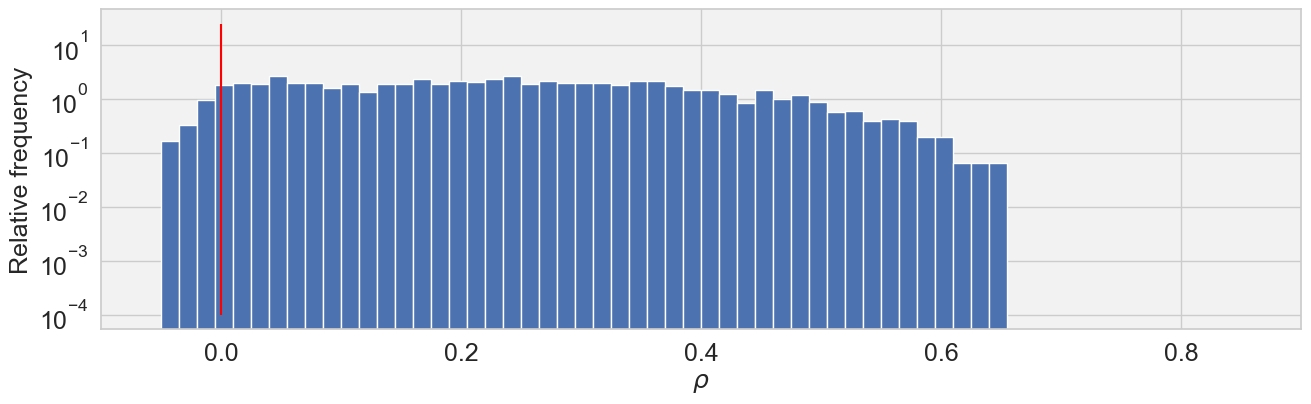

In [36]:
#print ("best joint score = %.3f"%best_joint_cc_score)
print ("best joint val cc = %.3f"% np.median(joined_val_cc))
for s,v in subject_val_cc.items():
    print ("subject %s: val cc = %.3f"%(s, np.median(v)))

fig=plt.figure(figsize=(12,4))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
_=plt.hist(joined_val_cc, bins=100, density=True, range=(-.5, 1.))
_=plt.vlines(x=[0], ymin=1e-4, ymax=25, color='r')
_=plt.yscale('log')
_=plt.xlim([-.1, 0.9])
_=plt.xlabel(r'$\rho$')
_=plt.ylabel('Relative frequency')

# Save results to file

In [37]:
torch.save({
            'subjects': trn_subjects,
            'sample_batch_size': sample_batch_size,
            'voxel_batch_size': voxel_batch_size,
            'holdout_frac': holdout_frac,  
            'lmask': lmask,
            'fmask': fmask,
            'tuning_masks': tuning_masks,
            'best_params': best_params, 
            'val_cc': subject_val_cc,
            'brain_nii_shape': brain_nii_shape,
            'voxel_index': voxel_idx,
            'voxel_roi': voxel_roi,
            'voxel_mask': voxel_mask
            },output_dir+'model_params_1000samples_500voxels')

In [165]:
output_dir

'C:/Data/nsd_test/output/multisubject/anet_fwrf_nsdgeneral_Apr-05-2025_0007/'